#  Stacking for the estimation of Treatment Effects

# 1. Generate data
generate data according to the same process as Nie X. and Wager S. (2018) 'Quasi-Oracle Estimation of Heterogeneous Treatment Effects'. a library is provided by `causalml` from uber (https://github.com/uber/causalml). 

the goal in simulating data : to provide different examples of data generating processes, in order to conclude upon the effectiveness of stacking for treatment effects in each situation. 

In an experimental setup, or a situation in which we have treated and untreated data, it is necessary to estimate the underlying distribution of the 'nuisance variables', the propensity score (the likelihood, given an observation's characteristics, to be treated), and the underlying treatment effect. As such, we simulate different X, propensity, and treatment functions.

`causalml` provides an implementation of each data generating function as seen in Nie & Wager, accessible through five possible modes passed to synthetic_data() :          

    `       1 for difficult nuisance components and an easy treatment effect.
            2 for a randomized trial.
            3 for an easy propensity and a difficult baseline.
            4 for unrelated treatment and control groups.
            5 for a hidden confounder biasing treatment.

!!!! talk here about how its useful to use the data generators from causal ml bc :
 - this allows us to generate as much data as we need in order to cross validate. we essentially always have a holdout set read to test.
 - we also need true treatment effects in order to set up a stacking pipeline, there is otherwise no way to estimate a stacking model without a true $\tau(X)$

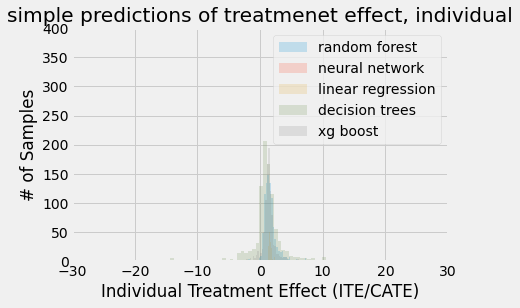

In [8]:
### YOU COULD DO THE DATA GENERATION THING HERE WITH CAUSALML, AND THEN CREATE A PIPELINE ENTIRELY WITH SKLEARN.
from causalml.dataset import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

np.random.seed(42) # does this seed affect the causalml generated stuff? i think no..
y_easy_t, X_easy_t, w_easy_t, tau_easy_t, b_easy_t, e_easy_t = simulate_nuisance_and_easy_treatment()
y_rand, X_rand, w_rand, tau_rand, b_rand, e_rand = simulate_randomized_trial()
y_easy_p, X_easy_p, w_easy_p, tau_easy_p, b_easy_p, e_easy_p = simulate_easy_propensity_difficult_baseline()
y_hidden, X_hidden, w_hidden, tau_hidden, b_hidden, e_hidden = simulate_hidden_confounder()

randF = RandomForestRegressor()
regNN = MLPRegressor()
regLR = LinearRegression()
regDT= DecisionTreeRegressor()
regXgb = XGBRegressor()

easy_t_preds = {}
def create_simple_ml_model(X, y, w, regressor):
    df = pd.DataFrame(data=X)
    df['assignment'] = w

    y_df = pd.DataFrame(data = y)
    reg = regressor.fit(df, y_df)

    X_neg = pd.DataFrame(data=X)
    X_neg['assignment'] = 0

    X_pos = pd.DataFrame(data=X)
    X_pos['assignment'] = 1
    ret = reg.predict(X_pos) / reg.predict(X_neg)
    return ret

def make_simple_predictions_for_stacking(X, y, w, regressor, name, dict):
    preds = create_simple_ml_model(X, y, w, regressor)
    dict[name] = preds

make_simple_predictions_for_stacking(X_easy_t, y_easy_t, w_easy_t, randF, 'randomForest', easy_t_preds)
make_simple_predictions_for_stacking(X_easy_t, y_easy_t, w_easy_t, regNN, 'NeuralNetwork', easy_t_preds)
make_simple_predictions_for_stacking(X_easy_t, y_easy_t, w_easy_t, regLR, 'linearRegression', easy_t_preds)
make_simple_predictions_for_stacking(X_easy_t, y_easy_t, w_easy_t, regDT, 'DecisionTrees', easy_t_preds)
make_simple_predictions_for_stacking(X_easy_t, y_easy_t, w_easy_t, regXgb, 'xgboost', easy_t_preds)

def multilayer_hist(dict):
    alpha = 0.2
    bins = 1000

    for name, predictions in dict.items():
        plt.hist(predictions, alpha=alpha, bins=bins, label=name)

    plt.axis([-30, 30, 0, 400])
    plt.title('simple predictions of individual treatment effect.')
    plt.xlabel('Individual Treatment Effect (ITE/CATE)')
    plt.ylabel('# of Samples')
    _=plt.legend()
    plt.show()

multilayer_hist(easy_t_preds)


##TODO: add average line to plot, add true treatment effect to plot.
##maybe add from causalml the estimated line for an  R learner alone to the plot
##ADD A TABLE FOR SOME IDEA OF THE MSE OR R SQUARED?? -- for this there has to be a better way to test (we only have predictions, not a whole test set. we can generate anoher one?)

In [ ]:
###THE STACKING PART!!
## we need a dict of predicitons vs. true effects. there MUST BE A CAUSALML WAY TO GENERATE A WHOLE TREATMENT GROUP.
def get_treated_obs_for_evaulation(data, y,  te, w):
    new_data = data[w == 1]
    new_outcome = y[w == 1]
    new_treatmente = te[w == 1]
    return (new_data, new_outcome, new_treatmente)


# 2. Learner selection -

## Grimmer et al, the 'T learner' and OLS.
Nie and Wager estimate treatement effects using (among other heterogenous treatment effect estimators) the 'T-Learner', we take this learner to be the same as that which is used in Grimmer (2017)
`causalml library also provides a T-learner as used in Grimmer (2017), where the treatment effect is estimated by simple comparison of the treated against the untreated.

The T Learner fits the functions $ \mu^*_w(x) = E(Y\mid X = x, W = w)$ separately for the treatment and the control groups (for $w \in{0, 1}$), and then esimates $\tau(x) = \mu_1(x) - \mu_0(x)$
The T learner (`BaseTRegressor()`) as implemented by `causalml` can be fed a machine learning model to estimate and predict treatment effects.
it will therefore be useful to have a stacking pipeline which includes several T-Learners, over different datasets in order to examine how well a Stacked T learner does under different data generating functions.

we can use this to stack estimates exactly as in Grimmer, and compare them to the R learners/DML learnings (also stacked) as in Nie, Wager
this would answer the questions:
 - how does stacking **without** double machine learning compare to the R learner on its own? Is there an advantage to using (the best..) R learner over simple stacking? and what kind of libraries are already available for such a pipeline?
 - how much can stacking help if we do not (can not) estimate propensity scores or distinct nuisance funcitions in the dataset?
 - how does stacking an R learner compare to (the best) single DML model?

the T learner does not explicitly account for propensity scores, or for the 'nuisance funciton' separate from the treatment effect.

the R learner, on the other hand:
 - R leaner, DML, etc etc.
 - The proposal from Nie and Wager for using some 'out of the box models and stacking the treatment effect estimations

The R learner can also be fed different models, and the results similarly stacked.

# 2. Feed in different models

We continue in the methodology of Nie and Wager, (QUOTE), by creating R learners using various methods to estimate the underlying functions for the X variables. 
(for the moment we will always use ElasticNetPropensityModel to estimate propensity scores.)

How many models can we feed in?

In [9]:
from causalml.inference.meta import BaseRRegressor, BaseTRegressor
import statsmodels.api as sm
import copy
import numpy as np

In [10]:
## can start with estimates from the T learner

learner_t_xgb = BaseTRegressor(learner=XGBRegressor())
learner_t_mlpr = BaseTRegressor(learner=MLPRegressor())
learner_t_lr = BaseTRegressor(learner=LinearRegression())

estimators = {'learner_t_xgb' : BaseTRegressor(learner=XGBRegressor()),
              'learner_t_mlpr': BaseTRegressor(learner=MLPRegressor()),
              'learner_t_lr' : BaseTRegressor(learner=LinearRegression())}

predicitons_t_models = get_synthetic_preds(simulate_nuisance_and_easy_treatment,
                                               n=50000,
                                               estimators=estimators)

In [11]:
'''
estimators = {'learner_xgb': BaseRRegressor(learner=XGBRegressor()),
              'learner_lr': BaseRRegressor(learner=LinearRegression()),
              'learner_dtr': BaseRRegressor(learner=DecisionTreeRegressor()),
              'learner_ctr': BaseRRegressor(learner=CausalTreeRegressor()),
              'learner_knr': BaseRRegressor(learner=KNeighborsRegressor()),
              'learner_svr': BaseRRegressor(learner=SVR())}
              '''
###would be cool to find some other working learners, and to start messing with the params of each!!!!
#learner_knr = BaseRRegressor(learner=KNeighborsRegressor())
#learner_svr = BaseRRegressor(learner=SVR())
#learner_ctr = BaseRRegressor(learner=CausalTreeRegressor())
#'learner_sgd': BaseRRegressor(learner=SGDRegressor())
#learner_nnr = BaseRRegressor(learner=MLPRegressor()) ##Multi-layer Perceptron regressor

estimators = {'learner_xgb': BaseRRegressor(learner=XGBRegressor()),
              'learner_lr': BaseRRegressor(learner=LinearRegression()),
              'learner_dtr': BaseRRegressor(learner=DecisionTreeRegressor())}

predictions = get_synthetic_preds(simulate_nuisance_and_easy_treatment,
                                               n=50000,
                                               estimators=estimators)

In [12]:
### THE STADCKING PART (AGAIN.)

y_stacking = predictions['generated_data']['tau']
pred_copy = copy.deepcopy(predictions)
pred_copy.pop('Actuals')
pred_copy.pop('generated_data')

### iterate over this better so you can add mroe models.
x_stacking = np.vstack((predictions['learner_xgb'], predictions['learner_lr'], predictions['learner_dtr'])).T

### this is using ridgeCV for the method of ols.
### grimmer require that the coefficients of the final stacking regression sum to 1.
### HOW CAN WE DO THIS IN SKLEARN WHILE STILL USING CAUSALML?

model = sm.OLS(y_stacking, x_stacking)
model2 = model.fit_regularized(alpha=0.0, L1_wt=1.0, start_params=None, profile_scale=False, refit=False)
print(model2.params)
print(sum(model2.params))

[ 7.21240195e-03  7.50673101e-01 -1.49106637e-04]
0.7577363962178616


this is actually a sad shortcoming of the `causalml` library, that it is not possible to feed models directly into sklearn.ensemble models.
normally an ensemble class from sklear woudl take a dict (i think..) of models and a dataset, do the entire pipeline, and then output the model.

if we would like to imitate grimmer we would also need a solution to the problem that we currently dont have a way to contstrain the ensemble coefficients such that they must sum to 1.

In [13]:
predictions_A = get_synthetic_preds(simulate_nuisance_and_easy_treatment, n=50000)
predictions_B = get_synthetic_preds(simulate_randomized_trial, n=50000)
predictions_C = get_synthetic_preds(simulate_easy_propensity_difficult_baseline, n=50000)
predictions_E = get_synthetic_preds(simulate_hidden_confounder, n=50000)